<a href="https://colab.research.google.com/github/MercyMoparthy/CNN-Project/blob/main/Model_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Data

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
#from tensorflow.keras.applications import ResNet32
from tensorflow.keras import layers, models, datasets, utils, optimizers, callbacks
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

## Data Loading and Augmentation

In [22]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

## Sample Data

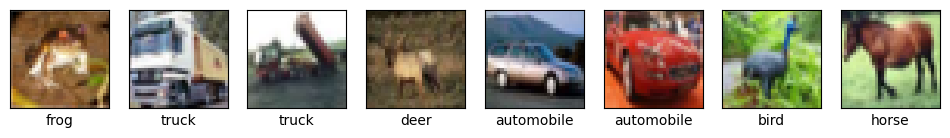

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# Function to plot sample images
def plot_sample_images(images, labels, class_names, num_images=8):
    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        # Labels are arrays like [[6]], so extract integer
        plt.xlabel(class_names[labels[i][0]])
    plt.show()

# Call the function to plot
plot_sample_images(train_images, train_labels, class_names)

## Data Augmentation

In [7]:
# Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)

## ResNet Model Architectire

In [14]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True):
    x = layers.Conv2D(num_filters,
                      kernel_size=kernel_size,
                      strides=strides,
                      padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    if batch_normalization:
        x = layers.BatchNormalization()(x)
    if activation:
        x = layers.Activation(activation)(x)
    return x

def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('Depth should be 6n+2 (e.g. 32, 44, 56, 110)')

    num_filters = 16
    num_res_blocks = (depth - 2) // 6

    inputs = layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)

    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first block but not first stack
                strides = 2  # downsample

            y = resnet_layer(x, num_filters=num_filters, strides=strides)
            y = resnet_layer(y, num_filters=num_filters, activation=None)

            if stack > 0 and res_block == 0:
                x = resnet_layer(x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)

            x = layers.add([x, y])
            x = layers.Activation('relu')(x)

        num_filters *= 2

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes,
                           activation='softmax',
                           kernel_initializer='he_normal')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


## Compile the Model

In [15]:
model = resnet_v1(input_shape=(32,32,3), depth=32)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 32, 32,    │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 32, 32,    │      2,320 │ activation_31[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 32, 32,    │      2,320 │ activation_32[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 32, 32,    │          0 │ activation_31[0]… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 32, 32,    │          0 │ add_15[0][0]      │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 32, 32,    │      2,320 │ activation_33[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 32, 32,    │      2,320 │ activation_34[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 32, 32,    │          0 │ activation_33[0]

 Total params: 470,218 (1.79 MB)

 Trainable params: 467,946 (1.79 MB)

 Non-trainable params: 2,272 (8.88 KB)

## Model Callbacks

In [16]:
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1)

## Train the ResNet Model

In [17]:
from sklearn.model_selection import train_test_split
x_train_new, x_val, y_train_new, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42
)

# Train using datagen on x_train_new
history = model.fit(
    datagen.flow(x_train_new, y_train_new, batch_size=64),
    validation_data=(x_val, y_val),
    epochs=20,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 68s 54ms/step - accuracy: 0.2651 - loss: 2.4946 - val_accuracy: 0.4146 - val_loss: 1.8363 - learning_rate: 1.0000e-04
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.4369 - loss: 1.7852 - val_accuracy: 0.4648 - val_loss: 1.7078 - learning_rate: 1.0000e-04
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.4906 - loss: 1.6589 - val_accuracy: 0.5150 - val_loss: 1.5773 - learning_rate: 1.0000e-04
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.5139 - loss: 1.5797 - val_accuracy: 0.5054 - val_loss: 1.6115 - learning_rate: 1.0000e-04
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.5429 - loss: 1.5106 - val_accuracy: 0.5280 - val_loss: 1.5730 - learning_rate: 1.0000e-04
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.5625 - loss: 1.4533 - val_accuracy: 0.5708 - val_loss: 1.4160 - learning_rate: 1.0000e-04
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accurac

## Evaluate the ResNet Model

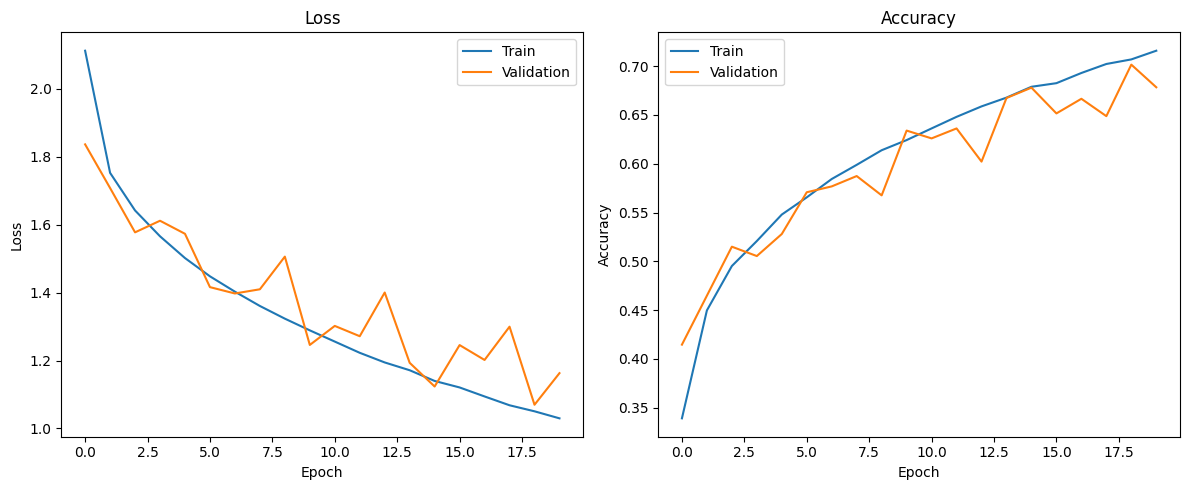

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Sample Visualization with Predictions

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

    airplane       0.77      0.69      0.73      1000
  automobile       0.88      0.83      0.85      1000
        bird       0.69      0.49      0.57      1000
         cat       0.56      0.49      0.52      1000
        deer       0.63      0.62      0.63      1000
         dog       0.79      0.47      0.59      1000
        frog       0.54      0.90      0.67      1000
       horse       0.81      0.71      0.76      1000
        ship       0.75      0.88      0.81      1000
       truck       0.70      0.89      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.69     10000
weighted avg       0.71      0.70      0.69     10000



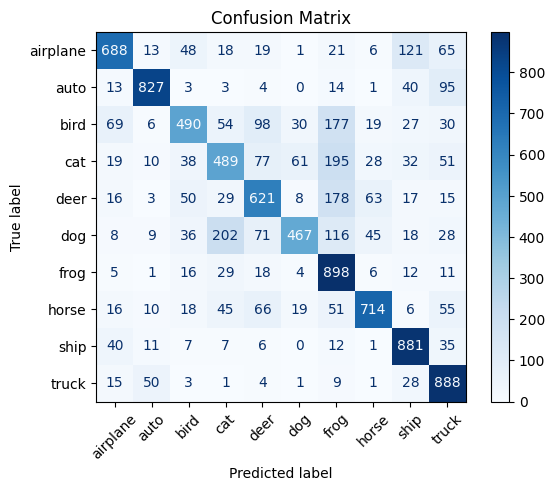

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test from one-hot encoding back to integer labels
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=[
    'airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'
]))

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    'airplane','auto','bird','cat','deer','dog','frog','horse','ship','truck'
])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [24]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.095895528793335
Test accuracy: 0.6963000297546387
